This notebook assumes you followed the guidelines for creating the dataset in the README.md file, but if you don't remember, here they are again:

- Ensure each poem is wrapped in double quotes: ("The sky is blue.")
- If there's a line break in the poem, either add an actual line break or use \n to represent one. If you use the latter (like I did), you'll need to convert it into an actual line break before training:
- If a poem begins with a double quote, you must double it ("Individuality" -> """Individuality"")
- If there's any internal quotes, they must also be doubled ("He said, "Hello"!" -> "He said, ""Hello""!")

Also be sure to connect to the NVIDIA T4 GPU before training.

# Preprocessing

In [24]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from google.colab import drive
from datasets import Dataset
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# Load in the data
path = "/content/drive/MyDrive/Colab Notebooks/LLM Project/data.csv"
df = pd.read_csv(path)
df.head()

,text,labels
0,Flesh craves flesh lingering want\nSkin plaste...,1
1,How does it feel\nTo glide across the diamond ...,1
2,Your wires wrapped around my beating heart\nUn...,1
3,"Oh, you're finally here\nTake me, take me away...",1
4,I dreamed a dream so beautiful it blinded my e...,1


In [3]:
# Function that preprocesses the CSV file and prepares the sets for training
def preprocess(df, shuffle=True):

  # Shuffle the data entries if when making the dataset you didn't mix up the entries like me
  if shuffle:
    df = df.sample(frac=1).reset_index(drop=True)

  # Convert the place holder \n characters into actual line breaks
  print("Before conversion:")
  print(df['text'][0])

  df['text'] = df['text'].apply(lambda x: x.replace("\\n", "\n"))

  # Check to see if conversion worked
  print("\nAfter conversion:")
  print(df['text'][0])

  # Split the data into training and test sets
  test_df = df.sample(frac=0.2, random_state=42)
  train_df = df.drop(test_df.index)

  # Check to see if the shapes are correct
  print("\nDataframe sizes:", test_df.shape, train_df.shape)

  # Convert the CSV files into Hugging Face Datasets for training
  train_dataset = Dataset.from_pandas(train_df).remove_columns(["__index_level_0__"])
  test_dataset = Dataset.from_pandas(test_df).remove_columns(["__index_level_0__"])

  print("\n")
  print(train_dataset)
  print(test_dataset)

  return test_df, train_df, train_dataset, test_dataset

In [4]:
test_df, train_df, train_dataset, test_dataset = preprocess(df, shuffle=True)

Before conversion:
I dreamed a dream so beautiful it blinded my eyes\n I dreamed a dream so enticing that I didn't want to live my life\nI dreamed a dream so wonderful I couldn't tell if it was real or I\nI dreamed a dream so terrifying I couldn't see or find

After conversion:
I dreamed a dream so beautiful it blinded my eyes
 I dreamed a dream so enticing that I didn't want to live my life
I dreamed a dream so wonderful I couldn't tell if it was real or I
I dreamed a dream so terrifying I couldn't see or find

Dataframe sizes: (6, 2) (24, 2)


Dataset({
    features: ['text', 'labels'],
    num_rows: 24
})
Dataset({
    features: ['text', 'labels'],
    num_rows: 6
})


In [5]:
test_df

,text,labels
27,"You laugh, you cry, you dream, you whine\n You...",1
15,as a child my mother once found me scraping my...,0
23,Still I hear that bell of death\nBehind me cro...,0
17,"A raw, thumping ache is for sure\nTo find prob...",0
8,True love watches the city skyline\nAdmiring f...,1
9,"""Individuality.""\nThe soldier had it engraved ...",0


In [6]:
train_df.head()

,text,labels
0,I dreamed a dream so beautiful it blinded my e...,1
1,Heart strung at the wrists\nUntil you hack at ...,1
2,Do you even think of me?\nUnless your phone di...,0
3,Stare into my clouded eyes\nSkin on skin feels...,1
4,Trapped in the water everything seems clear no...,1


In [7]:
# Function that tokenizes the plain text datasets for training
def tokenize_text(train_dataset, test_dataset):

    # Load in tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    # Tokenize the data
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    # Apply the tokenization
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Format datasets for PyTorch
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return train_dataset, test_dataset

In [8]:
train_dataset, test_dataset = tokenize_text(train_dataset, test_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

# Training GPT-2

Now, to unfreeze one layer of the model and the classification head for training. I'll also be changing the training arguments slightly.

In [9]:
# Load in pre-trained GPT-2 model with a classification head
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)

# Set padding token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model.config.pad_token_id = tokenizer.eos_token_id

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classification head
for param in model.score.parameters():
    param.requires_grad = True

# Unfreeze the last layer
for param in model.transformer.h[-1:].parameters():
    param.requires_grad = True

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-5, # Increasing learning rate to 5e-5 to also address the slow learning
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    seed=42
)

# Give the model trainer the arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.628800,2.920174
2,1.637800,2.801532
3,2.038500,2.571873
4,1.533900,2.270197
5,1.105600,2.084253
6,0.976000,2.002325
7,0.659300,1.950864
8,0.993800,1.892563
9,0.934600,1.857890
10,0.786100,1.852077


TrainOutput(global_step=120, training_loss=1.2536424160003663, metrics={'train_runtime': 54.6268, 'train_samples_per_second': 4.393, 'train_steps_per_second': 2.197, 'total_flos': 15677805035520.0, 'train_loss': 1.2536424160003663, 'epoch': 10.0})

In [11]:
# Save the trained model and tokenizer for feature extraction later
model.save_pretrained("./prototype_model")
tokenizer.save_pretrained("./prototype_model")

('./prototype_model/tokenizer_config.json',
 './prototype_model/special_tokens_map.json',
 './prototype_model/vocab.json',
 './prototype_model/merges.txt',
 './prototype_model/added_tokens.json')

In [12]:
# Check to see the directory containing the model is there
!ls

drive  prototype_model	results  sample_data


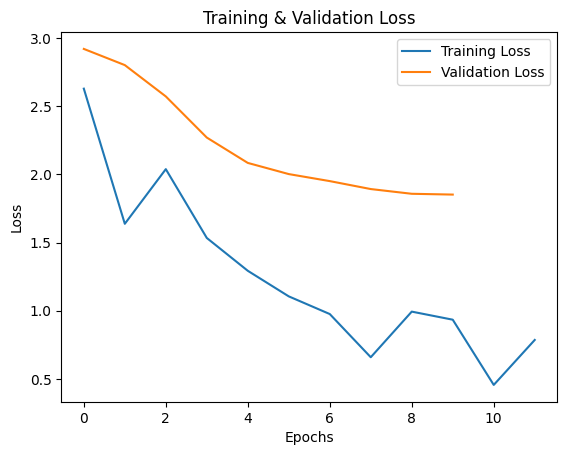

In [13]:
# Extract losses
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss  = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Plot the training and validation loss
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Extract Embeddings and Logistic Regression

Now, I'll feed the fine-tuned model the validation and training dataframes and extract the embeddings. These will then be given to a logistic regression model and evaluated.

In [14]:
# Function that feeds the whole dataframe into the fine tuned model and collects the embeddings
def get_embeddings(df, batch_size=8, model_path=None):

    # Load model and tokenizer
    model = GPT2ForSequenceClassification.from_pretrained(model_path)
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token

    # Use GPU if it's available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    texts = df["text"].tolist()
    embeddings = []

    # Get the embeddings
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model.transformer(**inputs)
            last_hidden_state = outputs.last_hidden_state

            pooled = last_hidden_state.mean(dim=1)

            embeddings.append(pooled.cpu().numpy())

    embeddings_np = np.vstack(embeddings)

    return embeddings_np

In [15]:
val_embeddings = get_embeddings(test_df, batch_size=8, model_path="./prototype_model")
train_embeddings = get_embeddings(train_df, batch_size=8, model_path="./prototype_model")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

To ensure that the GPT-2 embeddings are doing most of the work during inference, I'm keeping the logisitc regression model as simple as possible. Only scaling the embeddings, setting the random_state to 42, and increasing the max iterations to avoid a ConvergenceWarning. After implementing this, the results are very promising. It only misclassified 1 poem as my own, achieving an accuracy score of 83%.

Accuracy: 0.83


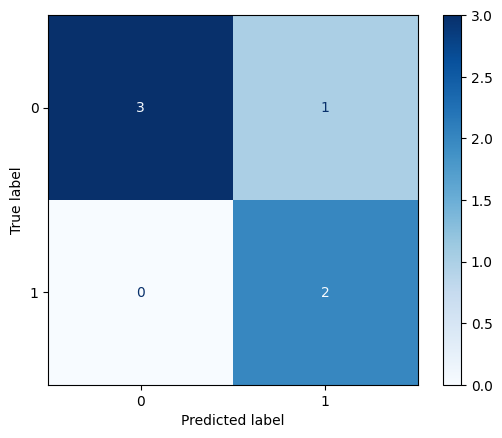

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.67      1.00      0.80         2

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6



In [25]:
# Split the data and scale the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_embeddings)
X_val_scaled = scaler.transform(val_embeddings)

y_true = test_df["labels"].values
y_train = train_df['labels'].values

# Initialize and train the model
lr = LogisticRegression(max_iter=1000, random_state=42)  # mostly default parameters
lr.fit(X_train_scaled, y_train)

# Run predictions
y_pred = lr.predict(X_val_scaled)

# Calculate metrics and display the confusion matrix
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_true, y_pred, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred))

Now, to write the predictions and truths for each poem into a text file.

In [30]:
# Write the test poems and their predictions into a text file
with open("results.txt", "w", encoding="utf-8") as f:

    for i, pred in enumerate(y_pred, 1):
        pred_str = "your poem" if pred == 1 else "not your poem"
        true_label = test_df['labels'].iloc[i-1]
        true_str = "your poem" if true_label == 1 else "not your poem"

        f.write(f"Poem {i}: predicted = {pred_str}, true = {true_str}\n")
        f.write(test_df['text'].iloc[i-1].strip() + "\n\n")

Now I'll create and write a prompt into a text file so that I can show it to GPT-5 in a chat session and see how it performs on the test set.

In [37]:
# Write a prompt to show GPT-5 into a text file
with open("prompt.txt", "w", encoding="utf-8") as f:
    f.write("You are tasked with identifying whether each poem below was written by a person called Diego or by someone else.\n")
    f.write("For each poem, respond with only the poem number and your answer in the following format:\n")
    f.write("Poem X: Written by Diego\n")
    f.write("or\n")
    f.write("Poem X: Written by someone else\n")
    f.write("Do not provide any explanations or additional text.\n\n")

    for i, poem in enumerate(test_df['text'], 1):
        f.write(f"Poem {i}:\n")
        f.write(poem.strip() + "\n\n")